<a href="https://colab.research.google.com/github/MinghanChu/DeepLearning-ZerosToGans/blob/main/Training_Deep_NN_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 990504.95it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160246.18it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1513412.91it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3564844.46it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

image.shape: torch.Size([1, 28, 28])
Label: 5


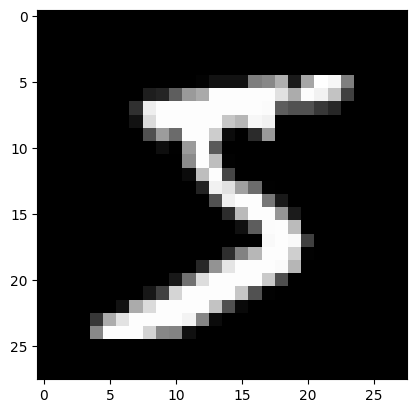

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


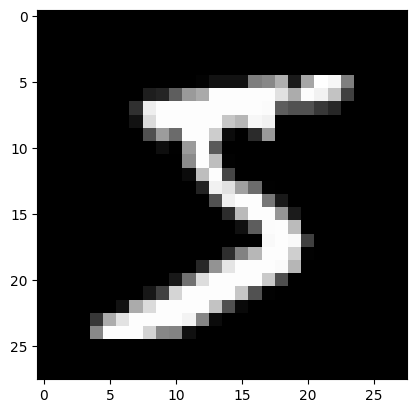

In [5]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [6]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [7]:
batch_size=128

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


+ `num_workers=4`: Setting the argument num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes

+ setting `pin_memory=True`, which enables **fast data transfer to CUDA-enabled GPUs**

+ setting `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different.

+ note no need to set `shuffle=True` for the validation data loader because the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


images.shape: torch.Size([128, 1, 28, 28])


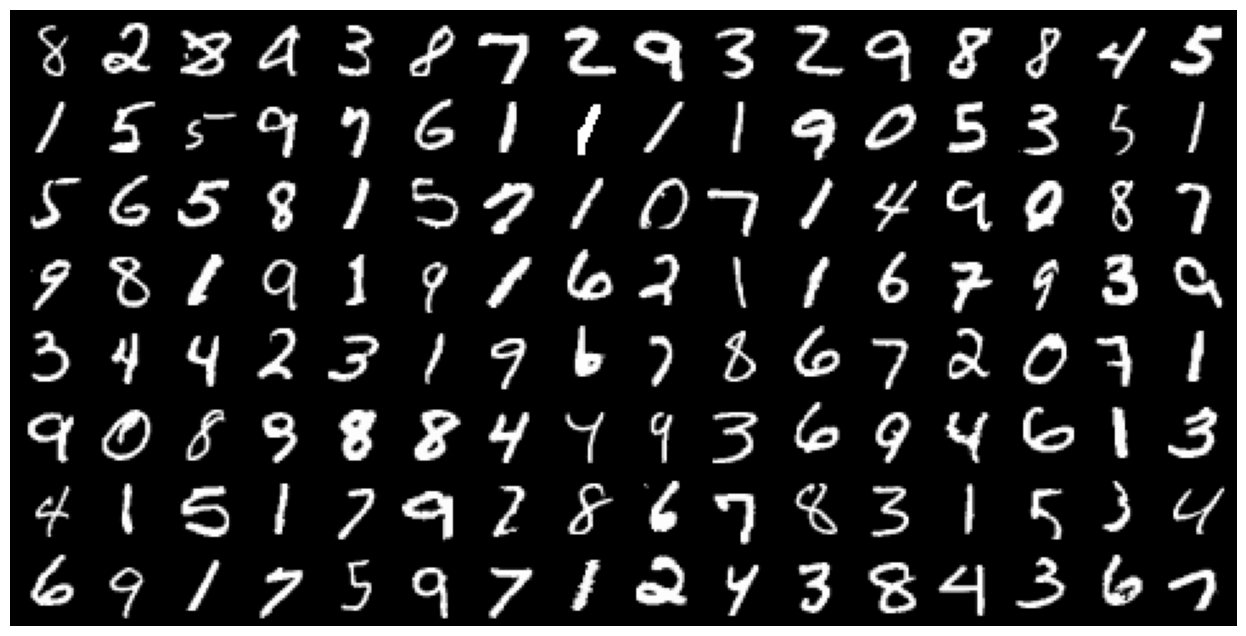

In [9]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a *hidden layer* and an *output layer*. Additionally, we'll use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture **non-linear relationships** between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [11]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our `hidden` layer. (Note the hidden layer is a linear model.) We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the *learning capacity* of the model.

In [12]:
input_size = inputs.shape[-1]
print(input_size)
hidden_size = 32

784


In [13]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [14]:
inputs.shape

torch.Size([128, 784])

In [15]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`.

In [16]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [17]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture line relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [18]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values **were replaced with 0**.

In [30]:
relu_outputs = F.relu(layer1_outputs)
print(relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

torch.Size([128, 32])
min(layer1_outputs): -0.772233247756958
min(relu_outputs): 0.0


Applying nonlinear activation function, `relu_outputs` and `inputs` do not have a linear relationship, e.g., `nn.Linear`. For each input certain outputs are activated (those with nonzero values) while others turned off (those with zero values).

Next, convert vectors of length `hidden_size` (originally not 10, in this particular example it is 32) in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

Let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model.

+ Mathematically: `output = input * weight^T + bias`

In [20]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size) # layer 2 is also based on a linear model
print(hidden_size)
print(output_size)

32
10


The nn.Linear layer in PyTorch (and similarly in many other deep learning frameworks) is designed to work with the feature dimension, which is always the second dimension of the input tensor when the input is a 2D tensor (i.e., batches of samples).

The call `layer2_outputs = layer2(relu_outputs)` will only work correctly if the size of `relu_outputs` is compatible with the expected input size of `layer2`

`layer2 = nn.Linear(hidden_size, output_size)` initializes a linear layer expecting input with `hidden_size` features.

`layer2(relu_outputs)` will work if `relu_outputs` has a shape `[batch_size, hidden_size]`

Ensure `hidden_size`in `nn.Linear(hidden_size, output_size)` matches the second dimension of `relu_outputs`

In [21]:
layer2_outputs = layer2(relu_outputs)
print(relu_outputs.shape)
print(layer2_outputs.shape)


torch.Size([128, 32])
torch.Size([128, 10])


As expected, `layer2_outputs` contains a batch of vectors of size 10. We can  now use this output to compute the loss using `F.cross_entropy`

In [22]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [28]:
print(layer2_outputs.shape)
layer2_outputs

torch.Size([128, 10])


tensor([[-0.0028,  0.0886, -0.0924,  ..., -0.0064, -0.0650,  0.1473],
        [ 0.0285,  0.0569, -0.0079,  ..., -0.0388, -0.0090,  0.2218],
        [-0.1558,  0.1068, -0.1433,  ...,  0.0894,  0.0064,  0.0278],
        ...,
        [-0.0796,  0.0960, -0.0764,  ..., -0.1156, -0.0313,  0.0915],
        [-0.0583,  0.0587, -0.0545,  ...,  0.0407, -0.1705,  0.2027],
        [ 0.0391,  0.0342, -0.1304,  ..., -0.0744,  0.0438,  0.0879]],
       grad_fn=<AddmmBackward0>)

In [26]:
labels.shape

torch.Size([128])

Thus, our model transforms

Cross-entropy is a widely used loss function in machine learning and statistics, particularly in the context of classification problems. It measures the **difference between two probability distributions**, often the **predicted probability distribution and the true probability distribution (or labels)**.

In [24]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3116, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`),

1.  `layer1_outputs = inputs @ layer1.weight.t() + layer1.bias`

followed by a non-linear activation (using `F.relu`),

2. `relu_outputs = F.relu(step1)`

followed by another linear transformation (using `layer2`).

3. `layer2_outputs = layer2(relu_outputs)`

Let's verify this by re-computing the output using basic matrix operations.

In [29]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [31]:
torch.allclose (outputs, layer2_outputs, 1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the **non-linear activation function** `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, **introducing non-linearity** makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can **also introduce new hidden layers and apply the same non-linear activation after each hidden layer**.

**The model we just created is called a neural network**. **A _deep neural network_ is simply a neural network with one or more hidden layers.** In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it **can _learn_ rich and complex non-linear relationships between inputs and targets**. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, **applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results**. Deep learning models often contain **millions of parameters, which can together capture far more complex relationships** than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

Key Goal: we need to understand what it really means regarding nonlinearity being introduced in the deep learning model.

Nonlinearity captures the behavior more close to the reality.

In [32]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

`layer2.weight @ layer1.weight`

This operation effectively combines the linear transformations of two layers into one. The resultant matrix can be seen as a **single layer's weight matrix** that directly maps the input of layer1 to the output of layer2.

The expression `layer1.bias @ layer2.weight.t() + layer2.bias` effectively transforms the bias of the first layer through the transposed weight matrix of the second layer and then shifts it by the bias of the second layer. This operation can be useful for combining and analyzing the effects of biases across multiple layers in a neural network.

In [33]:
combined_layer = nn.Linear(input_size, output_size)
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In the provided code snippet, you are creating a new linear layer (combined_layer) and manually setting its weights and biases based on the operations involving the weights and biases of two existing layers (layer1 and layer2).

`combined_layer = nn.Linear(input_size, output_size)
`
This initializes a new linear layer with the specified input and output sizes. This layer will have its own randomly initialized weights and biases.

`combined_layer.weight.data = layer2.weight @ layer1.weight
`

This line replaces the randomly initialized weights of combined_layer with the result of the matrix multiplication of `layer2.weight` and `layer1.weight`. The result of `layer2.weight @ layer1.weight` forms the new weight matrix for `combined_layer`.

`combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias`

This line replaces the **randomly initialized biases of `combined_layer`** with the result of a combination of `layer1.bias and layer2.bias`. Specifically, it computes the product of `layer1.bias` and the transpose of `layer2.weight`, then adds `layer2.bias` to it.


In [34]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [35]:
torch.allclose(outputs2, outputs3, 1e-3)

True